In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import resample

import shap 
import category_encoders as ce
from xgboost import XGBClassifier

import scikitplot as skplt

from joblib import dump, load

In [2]:
shap.initjs()

In [3]:
target = 'C_SEV'
numeric_features = ['C_VEHS', 'V_AGE','P_AGE','C_PERS']
categorical_features = ['C_MNTH','C_WDAY','C_HOUR','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF','P_SEX','P_SAFE','V_TYPE']
file = 'crash_transformed_c_sev.csv'
one_hot_categories = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'P_SEX']
target_categories = ['C_CONF', 'C_RCFG', 'C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','P_SAFE']


dtypes = {}
for feature in numeric_features:
    dtypes[feature] = 'float' 
for feature in categorical_features:
    dtypes[feature] = 'str' 


data = pd.read_csv(f'./data/{file}',dtype=dtypes)
X = data.drop(target,axis=1)
y = data[target]

In [4]:
def subsample_data(X,y):
    y_2 = resample(y[y==0], replace = True, n_samples = len(y[y==1]), random_state = 12345)
    y_resampled = pd.concat([y[y==1],y_2])
    data_resampled = X.join(y_resampled)
    data_resampled = data_resampled.dropna(subset=[y.name])
    _y = data_resampled[y.name].astype('int8')
    _x = data_resampled.drop(target,axis=1)
    return _x,_y

In [5]:
cf_file = './saved_models/cv.joblib'
CV = load(cf_file)

In [6]:
explainer = shap.TreeExplainer(CV.best_estimator_.named_steps['classifier'])
test_data,_ = subsample_data(X,y)
x_test_transformed = CV.best_estimator_.named_steps['columntransformer'].transform(test_data)

In [7]:
estimator_columns = numeric_features + list(CV.best_estimator_.named_steps['columntransformer'].transformers_[1][1].named_steps['encoder'].get_feature_names(one_hot_categories))+target_categories
test_data = pd.DataFrame(x_test_transformed,columns=estimator_columns).sample(100)
test_data

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,C_VEHS,V_AGE,P_AGE,C_PERS,C_MNTH_01,C_MNTH_02,C_MNTH_03,C_MNTH_04,C_MNTH_05,C_MNTH_06,...,P_SEX_M,P_SEX_missing,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SAFE
69303,-0.067863,-0.111407,-1.039815,1.377448,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.451377,0.361729,0.485397,0.501259,0.451483,0.589945,0.457476,0.448290
88534,-0.350623,0.949186,-0.801072,-0.644710,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.673292,0.624696,0.485397,0.501259,0.698733,0.589945,0.672708,0.676614
22666,-0.067863,-0.111407,-0.084843,-0.644710,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.451377,0.362381,0.544704,0.501259,0.451483,0.233327,0.457476,0.465367
5102,-0.067863,-0.288172,-0.920444,0.029342,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.451377,0.362381,0.485397,0.693490,0.451483,0.589945,0.457476,0.701844
26886,1.345942,-1.348765,-0.801072,-0.644710,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.187968,0.573288,0.455079,0.464527,0.559893,0.589945,0.457476,0.448290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110646,-0.067863,-1.171999,1.108871,0.703395,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.451377,0.362381,0.485397,0.501259,0.451483,0.589945,0.457476,0.448290
4900,-0.350623,-0.641703,-1.338244,1.377448,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.694917,0.584895,0.485397,0.501259,0.559893,0.470617,0.457476,0.465367
104978,-0.350623,0.418889,0.631385,-0.644710,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.673292,0.624696,0.485397,0.501259,0.719104,0.589945,0.672708,0.676614
106805,-0.350623,2.186543,-0.025158,-0.644710,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.673292,0.624696,0.485397,0.501259,0.451483,0.589945,0.457476,0.865804


In [8]:
shap_values =  explainer.shap_values(test_data)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [19]:
shap.force_plot(explainer.expected_value, shap_values[0], test_data.iloc[0,:])

In [23]:
#shap.force_plot(explainer.expected_value, shap_values[0][:100,:], features=test_data.iloc[:100, :])
shap.force_plot(explainer.expected_value, shap_values[:100,:], features=test_data.iloc[:100, :])

En el siguiente grafico se puede ver que las columnas C_CONF, P_SAFE y C_TRAF son las que mas impacto tienen en la prediccion del modelo

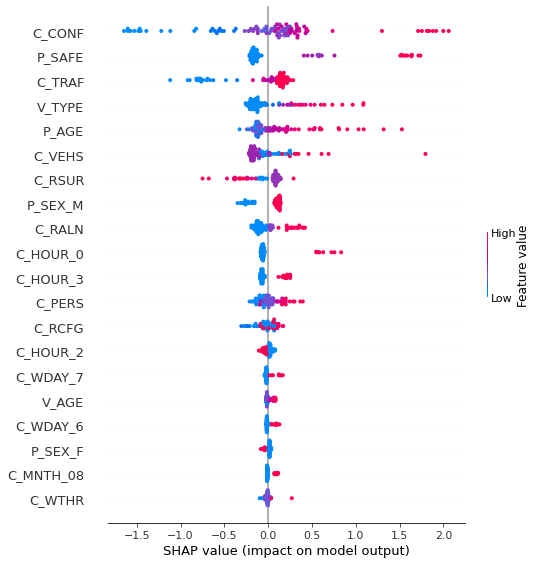

In [24]:
shap.summary_plot(shap_values, test_data)